# Time Series Forecasting

In [1]:
import pandas as pd
import numpy as np

In [2]:
data = pd.read_csv('Shoe_sales_clean.csv',
                  index_col = 'Date',
                  parse_dates = True)
data.head()

,Sales
Date,
2014-01-01,914.4
2014-01-02,1195.1
2014-01-03,1159.6
2014-01-04,1087.5
2014-01-05,876.4


In [3]:
df = data.rename(columns = {'Sales' : 'y'})
df.head()

,y
Date,
2014-01-01,914.4
2014-01-02,1195.1
2014-01-03,1159.6
2014-01-04,1087.5
2014-01-05,876.4


In [4]:
# set Python frequency to Daily
df = df.asfreq('D')
df.index

DatetimeIndex(['2014-01-01', '2014-01-02', '2014-01-03', '2014-01-04',
               '2014-01-05', '2014-01-06', '2014-01-07', '2014-01-08',
               '2014-01-09', '2014-01-10',
               ...
               '2016-12-22', '2016-12-23', '2016-12-24', '2016-12-25',
               '2016-12-26', '2016-12-27', '2016-12-28', '2016-12-29',
               '2016-12-30', '2016-12-31'],
              dtype='datetime64[ns]', name='Date', length=1096, freq='D')

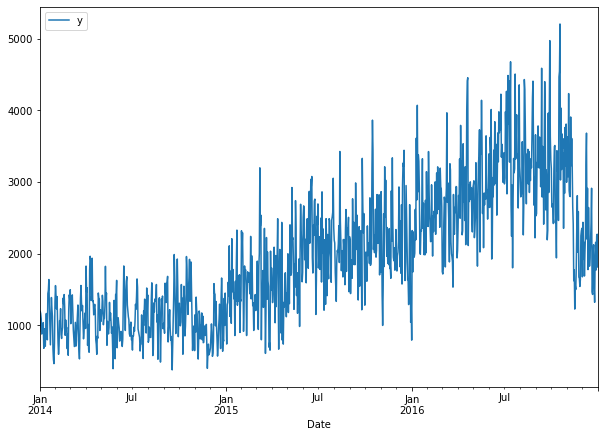

In [5]:
#Visualize the time series
df["y"].plot(figsize = (10, 7), legend = True);

In [6]:
from statsmodels.tsa.stattools import adfuller

In [7]:
stationarity = adfuller(df['y'])
stationarity

(-1.636503981359391,
 0.4640881420381872,
 18,
 1077,
 {'1%': -3.436436308605049,
  '5%': -2.8642273405849363,
  '10%': -2.568200833956216},
 16316.913517312601)

In [8]:
print('Augmented Dickey Fuller p-value: %F' % stationarity[1])

Augmented Dickey Fuller p-value: 0.464088


In [9]:
test_days = 61
training_set = df.iloc[:-test_days, :]
test_set = df.iloc[-test_days:, :]

In [10]:
training_set.tail()

,y
Date,
2016-10-27,2840.5
2016-10-28,3759.5
2016-10-29,3225.4
2016-10-30,3806.7
2016-10-31,2994.7


In [11]:
test_set.tail()

,y
Date,
2016-12-27,2156.5
2016-12-28,1770.3
2016-12-29,2243.7
2016-12-30,2269.2
2016-12-31,1812.4


In [12]:
print('Training set size:', training_set.shape)
print('Test set size:',test_set.shape)

Training set size: (1035, 1)
Test set size: (61, 1)


# Sarimax

In [13]:
from pmdarima import auto_arima

In [14]:
model = auto_arima(y = training_set['y'],
                  m = 7,
                  seasonal = True,
                  stepwise = False)

In [15]:
#Summary
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1035
Model:               SARIMAX(0, 1, 3)   Log Likelihood               -7819.018
Date:                Sun, 14 Aug 2022   AIC                          15648.037
Time:                        09:53:53   BIC                          15672.743
Sample:                             0   HQIC                         15657.412
                               - 1035                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      2.3324      0.720      3.239      0.001       0.921       3.744
ma.L1         -0.6619      0.027    -24.699      0.000      -0.714      -0.609
ma.L2         -0.0944      0.032     -2.991      0.003      -0.156      -0.033
ma.L3         -0.1966      0.025     -7.929      0.000      -0.245      -0.148
sigma2      2.162e+05   8650.010     24.992      0.000    1.99e+05    2.33e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):                40.21
Prob(Q):                              0.79   Prob(JB):                         0.00
Heteroskedasticity (H):               4.05   Skew:                             0.35
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.67
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [16]:
predictions_sarimax = pd.Series(model.predict(n_periods = test_days,
                                   X = test_days)).rename('SARIMAX')
predictions_sarimax.index = test_set.index
predictions_sarimax

Date
2016-11-01    3315.111855
2016-11-02    3283.041192
2016-11-03    3379.080806
2016-11-04    3381.413213
2016-11-05    3383.745620
                 ...     
2016-12-27    3505.030785
2016-12-28    3507.363192
2016-12-29    3509.695599
2016-12-30    3512.028006
2016-12-31    3514.360413
Freq: D, Name: SARIMAX, Length: 61, dtype: float64

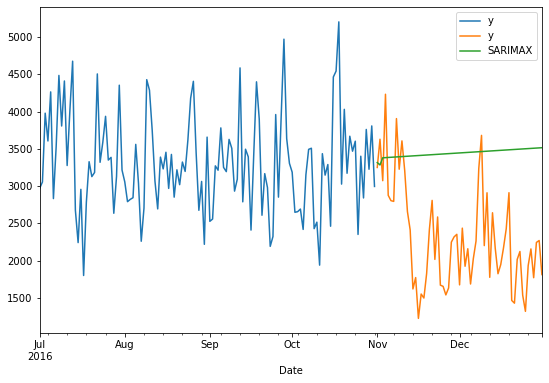

In [17]:
#Visualize the model
training_set['y']['2016-07-01':].plot(figsize = (9,6), legend = True)
test_set['y'].plot(legend = True)
predictions_sarimax.plot(legend = True);

## Sarimax Metrics

In [18]:
#MAE and RMSE
from sklearn.metrics import mean_squared_error, mean_absolute_error
print(round(mean_absolute_error(test_set['y'], predictions_sarimax), 0))
print(round(np.sqrt(mean_squared_error(test_set['y'], predictions_sarimax)), 0))

1208.0
1341.0


In [19]:
#MAPE function
def MAPE(y_true, y_pred):
  y_true, y_pred = np.array(y_true), np.array(y_pred)
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
MAPE(test_set['y'], predictions_sarimax)

64.2807953360949

### It appears out Sarimax model doesn't do well without exogenous regressors

# FB Prophet

In [21]:
import itertools 
from fbprophet import Prophet 

In [29]:
dfp = data.rename(columns = {'Sales' : 'y'})
dfp.head()

,y
Date,
2014-01-01,914.4
2014-01-02,1195.1
2014-01-03,1159.6
2014-01-04,1087.5
2014-01-05,876.4


In [25]:
#reset the index
df2 = dfp.reset_index()

In [26]:
df2.head()

,Date,y
0,2014-01-01,914.4
1,2014-01-02,1195.1
2,2014-01-03,1159.6
3,2014-01-04,1087.5
4,2014-01-05,876.4


In [27]:
#Check the date column is in datetime format
df2.Date

0      2014-01-01
1      2014-01-02
2      2014-01-03
3      2014-01-04
4      2014-01-05
          ...    
1091   2016-12-27
1092   2016-12-28
1093   2016-12-29
1094   2016-12-30
1095   2016-12-31
Name: Date, Length: 1096, dtype: datetime64[ns]

In [30]:
df2 = df2.rename(columns = {'Date' : 'ds'})
df2.head()

,ds,y
0,2014-01-01,914.4
1,2014-01-02,1195.1
2,2014-01-03,1159.6
3,2014-01-04,1087.5
4,2014-01-05,876.4


In [32]:
test_days = 61
training_set2 = df2.iloc[:-test_days, :]
test_set2 = df2.iloc[-test_days:, :]

In [33]:
training_set2.tail()

,ds,y
1030,2016-10-27,2840.5
1031,2016-10-28,3759.5
1032,2016-10-29,3225.4
1033,2016-10-30,3806.7
1034,2016-10-31,2994.7


In [34]:
test_set2.tail()

,ds,y
1091,2016-12-27,2156.5
1092,2016-12-28,1770.3
1093,2016-12-29,2243.7
1094,2016-12-30,2269.2
1095,2016-12-31,1812.4


In [35]:
m = Prophet(growth = 'linear',
           yearly_seasonality = True,
           weekly_seasonality = True,
           daily_seasonality = False,
           seasonality_mode = 'multiplicative',
           seasonality_prior_scale = 10,
           changepoint_prior_scale = 0.05)

In [36]:
m.fit(training_set2)

In [37]:
#Create future dataframe
future = m.make_future_dataframe(periods = len(test_set2),
                                freq = 'D')

In [39]:
forecast = m.predict(future)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2014-01-01,949.885820,272.516672,1404.799580,949.885820,949.885820,-0.125479,-0.125479,-0.125479,0.018064,0.018064,0.018064,-0.143543,-0.143543,-0.143543,0.0,0.0,0.0,830.695011
1,2014-01-02,950.659452,183.125129,1445.463039,950.659452,950.659452,-0.147700,-0.147700,-0.147700,-0.015233,-0.015233,-0.015233,-0.132467,-0.132467,-0.132467,0.0,0.0,0.0,810.246821
2,2014-01-03,951.433084,237.818309,1422.134542,951.433084,951.433084,-0.128504,-0.128504,-0.128504,-0.008522,-0.008522,-0.008522,-0.119982,-0.119982,-0.119982,0.0,0.0,0.0,829.169868
3,2014-01-04,952.206716,238.609528,1460.006581,952.206716,952.206716,-0.125097,-0.125097,-0.125097,-0.018843,-0.018843,-0.018843,-0.106254,-0.106254,-0.106254,0.0,0.0,0.0,833.088633
4,2014-01-05,952.980348,297.964285,1460.509947,952.980348,952.980348,-0.093597,-0.093597,-0.093597,-0.002120,-0.002120,-0.002120,-0.091477,-0.091477,-0.091477,0.0,0.0,0.0,863.784193


In [40]:
predictions_prophet = forecast.yhat[-test_days:].rename('Prophet')
predictions_prophet[:5]

1035    3332.961893
1036    3327.327128
1037    3176.020037
1038    3159.538191
1039    3084.672641
Name: Prophet, dtype: float64

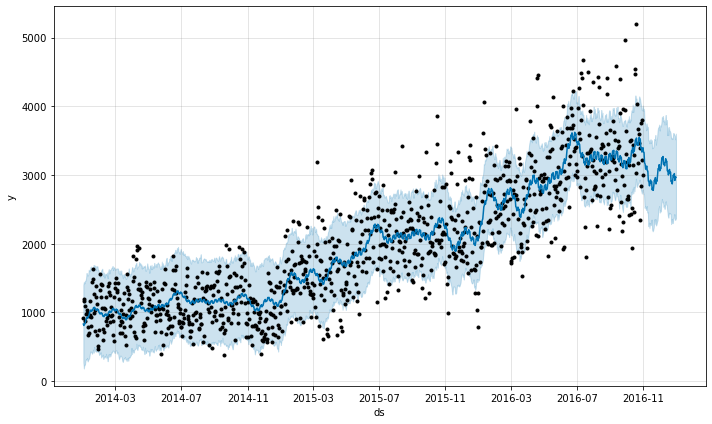

In [41]:
m.plot(forecast);

C:\Users\richj\anaconda3\envs\Forecast1\lib\site-packages\fbprophet\plot.py:422: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticklabels)
C:\Users\richj\anaconda3\envs\Forecast1\lib\site-packages\fbprophet\plot.py:422: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticklabels)


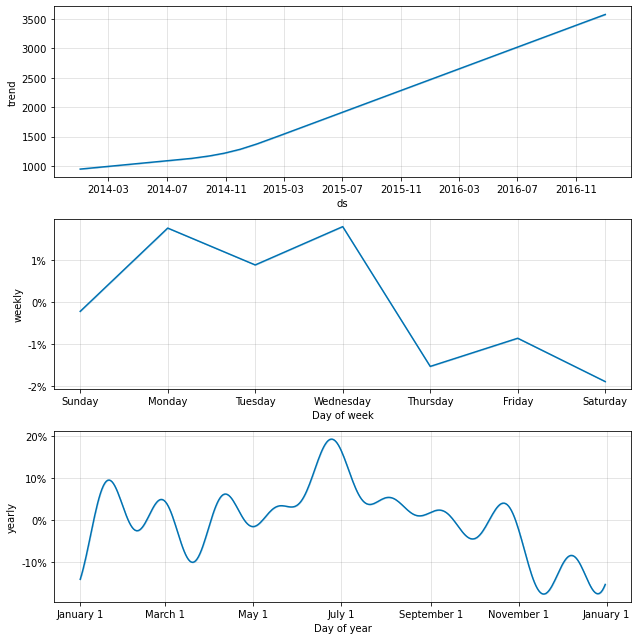

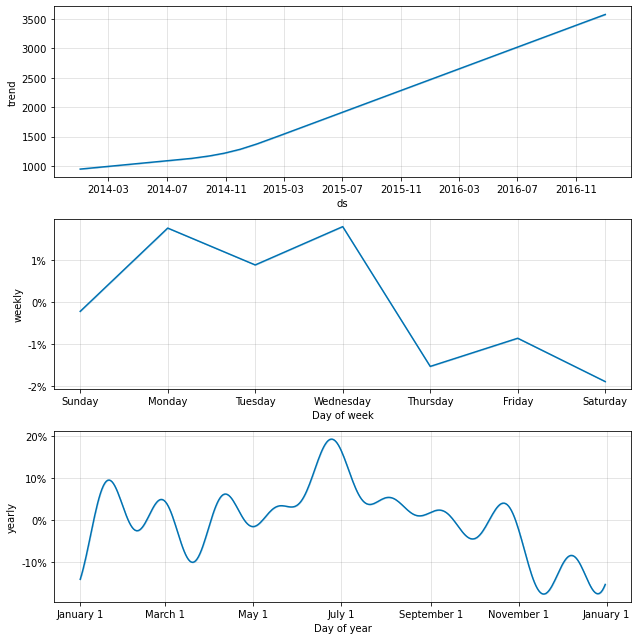

In [46]:
m.plot_components(forecast)

In [47]:
#MAE and RMSE

print(round(mean_absolute_error(test_set['y'], predictions_prophet), 0))
print(round(np.sqrt(mean_squared_error(test_set['y'], predictions_prophet)), 0))

859.0
972.0


In [48]:
#MAPE function
def MAPE(y_true, y_pred):
  y_true, y_pred = np.array(y_true), np.array(y_pred)
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
MAPE(test_set['y'], predictions_prophet)

45.63755192570201

## Cross Validation

In [49]:
from fbprophet.diagnostics import cross_validation
df_cv = cross_validation(m,
                        horizon = '61 days',
                        initial = '540 days',
                        parallel = 'processes')
df_cv.head()

INFO:fbprophet:Making 15 forecasts with cutoffs between 2015-07-01 00:00:00 and 2016-08-31 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000028D651D3588>


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2015-07-02,1912.586418,1414.404618,2398.436183,1797.6,2015-07-01
1,2015-07-03,1795.453889,1289.435390,2240.352077,1978.6,2015-07-01
2,2015-07-04,1819.897280,1332.058842,2265.771027,2233.0,2015-07-01
3,2015-07-05,1805.433723,1313.848142,2295.269774,1778.0,2015-07-01
4,2015-07-06,1802.372834,1288.943391,2292.029294,1998.0,2015-07-01


In [50]:
#MAE and RMSE
print(round(mean_absolute_error(df_cv['y'], df_cv['yhat']), 0))
print(round(np.sqrt(mean_squared_error(df_cv['y'], df_cv['yhat'])), 0))
print(MAPE(df_cv['y'], df_cv['yhat']))

488.0
624.0
19.835005067872224


# Conclusion

### FbProphet has a considerably better Mean Absolute Percentage Error than did the Sarimax and of the two is the model I would go with
